In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[1],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1048)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

In [2]:
% matplotlib inline

import matplotlib.image as img
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import InceptionResNetV2

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy import stats
from PIL import Image 
from mtcnn import MTCNN


Found 190632 images belonging to 2 classes.
Found 47656 images belonging to 2 classes.
x_data shape :  (20, 299, 299, 3)
t_data shape :  (20,)
[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1.]


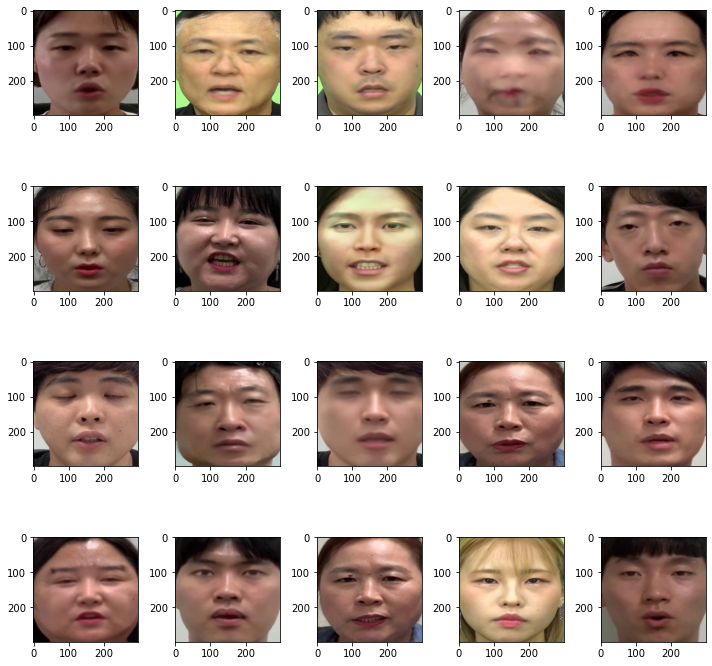

2


In [3]:

train_dir = './data/project_deepfake/train_new'
# validation_dir = './data/deepfake_ex/dataset/validation'


# ImageDataGenerator 생성
train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)
# validation_datagen = ImageDataGenerator(rescale=1/255)


train_generator = train_datagen.flow_from_directory(
    train_dir, 
    classes=['real','fake'], 
    target_size=(299,299), 
    batch_size=20, 
    class_mode='binary', subset='training') 
validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    classes=['real','fake'], 
    target_size=(299,299), 
    batch_size=20, 
    class_mode='binary', subset='validation') 

# generator에서 출력된 데이터의 shape확인
for x_data, t_data in train_generator:
    print('x_data shape : ', x_data.shape) # (20,299,299,3)
    print('t_data shape : ', t_data.shape) # (20,)
    break;

fig = plt.figure(figsize=(10,10))
axs = []

for i in range(20):
    axs.append(fig.add_subplot(4,5,i+1))
    
for x_data, t_data in train_generator:
    for idx, img_data in enumerate(x_data): # idx => 0~19 , img_data =>(150,150,3)
        axs[idx].imshow(img_data)
    print(t_data)
    break;
    
fig.tight_layout()
plt.show()

nr_of_classes = len(train_generator.class_indices)
print(nr_of_classes)

In [5]:

callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',  # 검증 정확도 모니터링
                                                   patience=5),             # 1 epoch보다 더 길게 정확도 향상되지 않으면 훈련 중지
                  
                  tf.keras.callbacks.ModelCheckpoint(filepath='./deepfake_sampling_model_1111.h5',
                                                     monitor='val_loss',    # 검증 loss 모니터링
                                                     save_best_only=True),  # 가장 좋은 모델을 저장
                  
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',  # 검증 loss 모니터링
                                                      factor=0.1,           # 콜백 호출시 학습률 10배로 줄임
                                                      patience=5)]          # 검증손실이 해당 epoch만큼 좋아지지 않으면 콜백 호출

In [7]:
# conv_base = InceptionResNetV2(weights='imagenet',
#               include_top=False,
#               input_shape=(224, 224, 3))

# print(conv_base.summary())

# conv_base.trainable = False  # Convolution Layer 동결

# model = Sequential()

# model.add(conv_base)

# model.add(GlobalAveragePooling2D())
# model.add(Dropout(rate=0.5))

# model.add(Dense(units=512, activation='relu'))
# model.add(Dense(units=1, activation='sigmoid'))
# print(model.summary())

with tf.device('/device:GPU:1'):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(299, 299, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.5))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())    
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    print(model.summary())
    


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 35, 35, 128)      

In [8]:

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [9]:
with tf.device('/device:GPU:1'):
    history = model.fit(train_generator,
                        steps_per_epoch=2000,  #  batch_size * steps_per_epoch이 train데이타의 양보다 크면 안됨!!!!!
                        epochs=30,
                        validation_data=validation_generator,
                        validation_steps=50)
    
model.save('./deepfake_sampling_model_1111.h5')
    

Epoch 1/30
2000/2000 [==============================] - 398s 199ms/step - loss: 0.2747 - accuracy: 0.8808 - val_loss: 0.1928 - val_accuracy: 0.9310
Epoch 2/30
2000/2000 [==============================] - 408s 204ms/step - loss: 0.1115 - accuracy: 0.9574 - val_loss: 0.1947 - val_accuracy: 0.9180
Epoch 3/30
2000/2000 [==============================] - 399s 199ms/step - loss: 0.0708 - accuracy: 0.9741 - val_loss: 0.1768 - val_accuracy: 0.9330
Epoch 4/30
2000/2000 [==============================] - 398s 199ms/step - loss: 0.0498 - accuracy: 0.9827 - val_loss: 0.2128 - val_accuracy: 0.9220
Epoch 5/30
2000/2000 [==============================] - 399s 199ms/step - loss: 0.0419 - accuracy: 0.9854 - val_loss: 0.0784 - val_accuracy: 0.9690
Epoch 6/30
2000/2000 [==============================] - 398s 199ms/step - loss: 0.0359 - accuracy: 0.9879 - val_loss: 0.1067 - val_accuracy: 0.9650
Epoch 7/30
2000/2000 [==============================] - 397s 199ms/step - loss: 0.0317 - accuracy: 0.9883 - val_

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


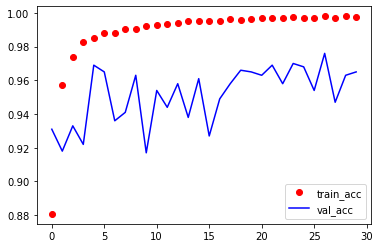

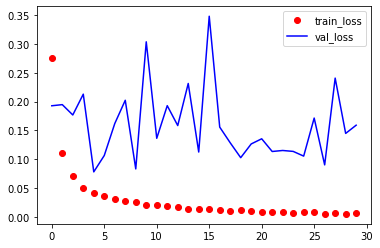

In [10]:
% matplotlib inline
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

print(history.history.keys())
plt.plot(history.history['accuracy'], 'bo', color='r', label='train_acc')
plt.plot(history.history['val_accuracy'], 'b', color='b', label='val_acc')
plt.legend()
plt.show()
plt.plot(history.history['loss'], 'bo', color='r', label='train_loss')
plt.plot(history.history['val_loss'], 'b', color='b', label='val_loss')
plt.legend()
plt.show()

In [ ]:
# 기학습 된 모델 불러오기
model = tf.keras.models.load_model('./deepfake_sampling_model_1111.h5')

In [11]:

path_test = './data/project_deepfake/test/test_600x600/'
df = pd.read_csv('./data/project_deepfake/sample_submission.csv') 


id_list = df.iloc[:,0].values 
print(len(id_list))

id_list=[path_test + num for num in id_list]

image_w = 299 
image_h = 299 
 
test_img_arr = [] 
prediction=[]
batch_size=20                     
steps=len(id_list)//batch_size
print('-'*70)

def score(s):
    if s >= 0.5:
        return 1
    else:
        return 0
    
# print(prediction)
detector = MTCNN()

for e in range(steps):
    for i, f in enumerate(id_list[e*batch_size:(e+1)*batch_size]): 
        img = Image.open(f) 
        # print(f)
        # img = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB)
        img = img.convert("RGB") 
        img = img.resize((image_w, image_h)) 
        # print(img.shape)
        data = np.asarray(img)
        data = data/255                # rescale
        test_img_arr.append(data)  

    test_img_arr = np.array(test_img_arr)               
    result = model.predict(test_img_arr)
    pred = [score(s) for s in result]
    prediction.append(pred)    
    test_img_arr = []
    print(f'Step {e+1}/ {steps}', end='\n')
print('-'*70)

4100
----------------------------------------------------------------------
Step 1/ 205
Step 2/ 205
Step 3/ 205
Step 4/ 205
Step 5/ 205
Step 6/ 205
Step 7/ 205
Step 8/ 205
Step 9/ 205
Step 10/ 205
Step 11/ 205
Step 12/ 205
Step 13/ 205
Step 14/ 205
Step 15/ 205
Step 16/ 205
Step 17/ 205
Step 18/ 205
Step 19/ 205
Step 20/ 205
Step 21/ 205
Step 22/ 205
Step 23/ 205
Step 24/ 205
Step 25/ 205
Step 26/ 205
Step 27/ 205
Step 28/ 205
Step 29/ 205
Step 30/ 205
Step 31/ 205
Step 32/ 205
Step 33/ 205
Step 34/ 205
Step 35/ 205
Step 36/ 205
Step 37/ 205
Step 38/ 205
Step 39/ 205
Step 40/ 205
Step 41/ 205
Step 42/ 205
Step 43/ 205
Step 44/ 205
Step 45/ 205
Step 46/ 205
Step 47/ 205
Step 48/ 205
Step 49/ 205
Step 50/ 205
Step 51/ 205
Step 52/ 205
Step 53/ 205
Step 54/ 205
Step 55/ 205
Step 56/ 205
Step 57/ 205
Step 58/ 205
Step 59/ 205
Step 60/ 205
Step 61/ 205
Step 62/ 205
Step 63/ 205
Step 64/ 205
Step 65/ 205
Step 66/ 205
Step 67/ 205
Step 68/ 205
Step 69/ 205
Step 70/ 205
Step 71/ 205
Step 72/ 2

In [12]:
# 제출파일 생성

df = pd.DataFrame({'path': df.iloc[:,0].values, 
                   'y': np.array(prediction).ravel()}, 
                    columns = ['path','y']) 

display(df) 

df.to_csv (r'./data/project_deepfake/sample_submisstion_sampling_1111.csv', index = False, header=True) 

,path,y
0,leaderboard/image_00000.jpg,0
1,leaderboard/image_00001.jpg,0
2,leaderboard/image_00002.jpg,0
3,leaderboard/image_00003.jpg,0
4,leaderboard/image_00004.jpg,1
...,...,...
4095,leaderboard/image_04095.jpg,1
4096,leaderboard/image_04096.jpg,0
4097,leaderboard/image_04097.jpg,1
4098,leaderboard/image_04098.jpg,0
